References

Very Deep Convolutional Networks for Large-Scale Image Recognition: please cite this paper if you use the VGG models in your work.

In [1]:
import os
import gc
import cv2
import csv
import h5py
import random
import numpy as np
from utils import *
import pickle as pkl
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
from keras import backend as K

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, ShuffleSplit

np.set_printoptions(suppress=True)

Using TensorFlow backend.


In [2]:
# Paths and Variables
anticlockwise_goodride_data_path = "../../Simulator_Data/Behavioral_Cloning/track1_anticlockwise_goodride/"
clockwise_ride_data_path = "../../Simulator_Data/Behavioral_Cloning/udacity_sample_driving_data/data/"
recovery_ride_data_path = "../../Simulator_Data/Behavioral_Cloning/track1_recovery_ride/"
more_recovery_ride_data_path = "../../Simulator_Data/Behavioral_Cloning/track1_recovery_ride_more/"
h5_data_path = "../../Simulator_Data/Behavioral_Cloning/image_data.h5"
model_path = "./model/"

batch_size = 32
image_shape = (160,320,3)

#### Prepare and Save Dataset (DO NOT RE-EXECUTE THIS SECTION)

In [3]:
lines = []
images_fnames = []  # list image paths
image_measurements = [] # list of corresponding steering angle

## Anticlockwise drive
with open(os.path.join(anticlockwise_goodride_data_path, "driving_log.csv")) as csv_file:
    csv_reader = csv.reader(csv_file)
    for row in csv_reader:
        lines.append(row)

## Recovery ride (clockwise + anticlockwise)
with open(os.path.join(recovery_ride_data_path, "driving_log.csv")) as csv_file:
    csv_reader = csv.reader(csv_file)
    for row in csv_reader:
        lines.append(row)

## More Recovery ride (clockwise)
with open(os.path.join(more_recovery_ride_data_path, "driving_log.csv")) as csv_file:
    csv_reader = csv.reader(csv_file)
    for row in csv_reader:
        lines.append(row)

## Clockwise drive (sample data from Udacity)
with open(os.path.join(clockwise_ride_data_path, "driving_log.csv")) as csv_file:
    csv_reader = csv.reader(csv_file)
    # skip the header here!
    headers = next(csv_reader)
    for row in csv_reader:
        # update relative path
        row[0] = os.path.join(clockwise_ride_data_path, row[0])
        lines.append(row)

# get the image file names and steering measurements
for line in lines:
    # first column is center image name. 
    images_fnames.append(line[0])
    image_measurements.append(float(line[3]))

print("Number of images (# X): ", len(images_fnames))
print("# Y:", len(image_measurements))

Number of images (# X):  34608
# Y: 34608


Image Shape: (160, 320, 3)


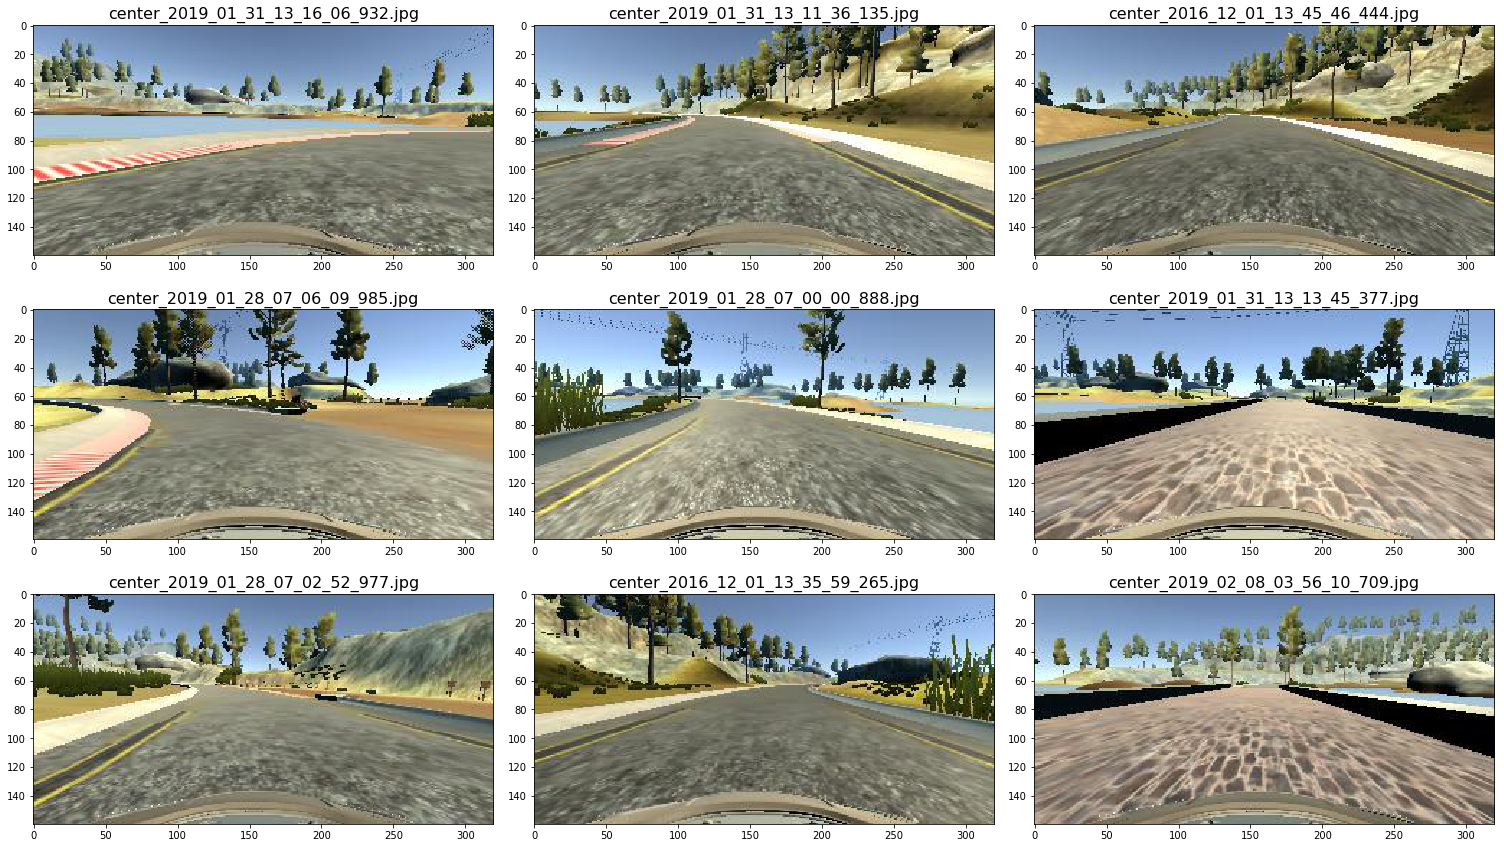

In [7]:
# Check out few sample images
images = []
names = []
for idx in random.sample(range(len(images_fnames)), 9):
    fname = images_fnames[idx]
    images.append(cv2_imread_rgb(fname))
    names.append(os.path.basename(fname))

print("Image Shape:", images[0].shape)

plot_images(images, titles=names, fontsize=16)

In [8]:
del images
del names

##### Create and Save Training data

In [9]:
X_train = []
y_train = []

# get the image file names and steering measurements
for fname in images_fnames:
    X_train.append(cv2_imread_rgb(fname))
    
X_train = np.array(X_train)
y_train = np.array(image_measurements)
X_train, y_train = shuffle(X_train, y_train, random_state=0)
image_shape = X_train[0].shape

In [10]:
print("Train X shape:", X_train.shape)
print("Train Y shape:", y_train.shape)
print("Image shape:", image_shape)


Train X shape: (34608, 160, 320, 3)
Train Y shape: (34608,)
Image shape: (160, 320, 3)


In [11]:
## Save the training data as HDF5 file
## The steering_angle measurement is float64, but save it as float32,
## as it doesn't reduce the resolution much in this case.
with h5py.File(h5_data_path, 'w') as f:
    f.create_dataset('images', data=X_train, dtype=np.uint8)
    f.create_dataset('steering_angles', data=y_train, dtype=np.float32)

#### Load Dataset

In [3]:
hf = h5py.File(h5_data_path, 'r')

In [4]:
X_train_all = hf.get('images')
y_train_all = hf.get('steering_angles')

In [5]:
X_train_all.shape, y_train_all.shape

((34608, 160, 320, 3), (34608,))

In [6]:
type(X_train_all[0][0,0,0]), type(y_train_all[0])

(numpy.uint8, numpy.float32)

In [7]:
## Create Trainng and Validation sets
trn_inx, val_idx = train_test_split(range(X_train_all.shape[0]), test_size = 0.2, random_state = 101)
# h5 file needs indices in increasing order
trn_inx, val_idx = sorted(trn_inx), sorted(val_idx)

print(len(trn_inx), len(val_idx))

27686 6922


In [8]:
# read the train and validation sets (this may take sometime)
X_train = X_train_all[trn_inx]
y_train = y_train_all[trn_inx]
X_val = X_train_all[val_idx]
y_val = y_train_all[val_idx]

In [9]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((27686, 160, 320, 3), (27686,), (6922, 160, 320, 3), (6922,))

In [10]:
type(X_train[0][0,0,0]), type(y_train[0])

(numpy.uint8, numpy.float32)

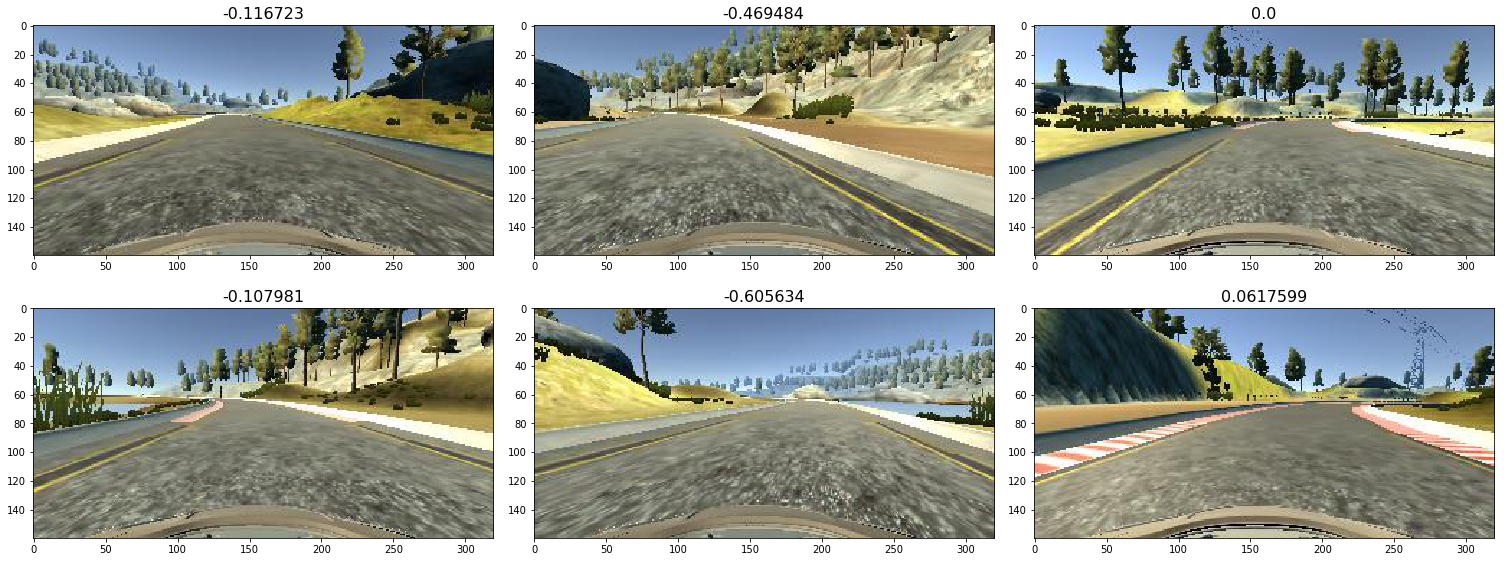

In [11]:
## Check a few train images and steering angles
plot_images(X_train[:6], titles=y_train[:6], fontsize=16)

In [12]:
del X_train_all
del y_train_all
# del train_gen
gc.collect()

29647

#### Data Generation and Augmentation

In [9]:
# # Custom ImageDataGenerator to flip images and the steering angle

# # Train Image generator
# ImageGenerator = image.ImageDataGenerator()
# TrainImageGenerator = ImageGenerator.flow(X_train, y_train, batch_size=batch_size, seed=101)

# def trainGeneratorFunction():
#     while True:
#         X, y = TrainImageGenerator.next()
#         fliplr = [random.randint(0, 1) for _ in range(X.shape[0])]
#         for i, flip in enumerate(fliplr):
#             if flip == 1:
#                 X[i] = np.fliplr(X[i])
#                 if y[i] != 0.0:
#                     y[i] = -y[i]
            
#         yield X, y
        
# train_gen = trainGeneratorFunction()

In [13]:
# Train Image Generator
train_gen = image.ImageDataGenerator().flow(X_train, y_train, batch_size=batch_size, seed=101)

In [14]:
# Validation Image Generator
val_gen = image.ImageDataGenerator().flow(X_val, y_val, batch_size=batch_size, seed=201)

In [15]:
# Check train image generator
X, y = next(train_gen)

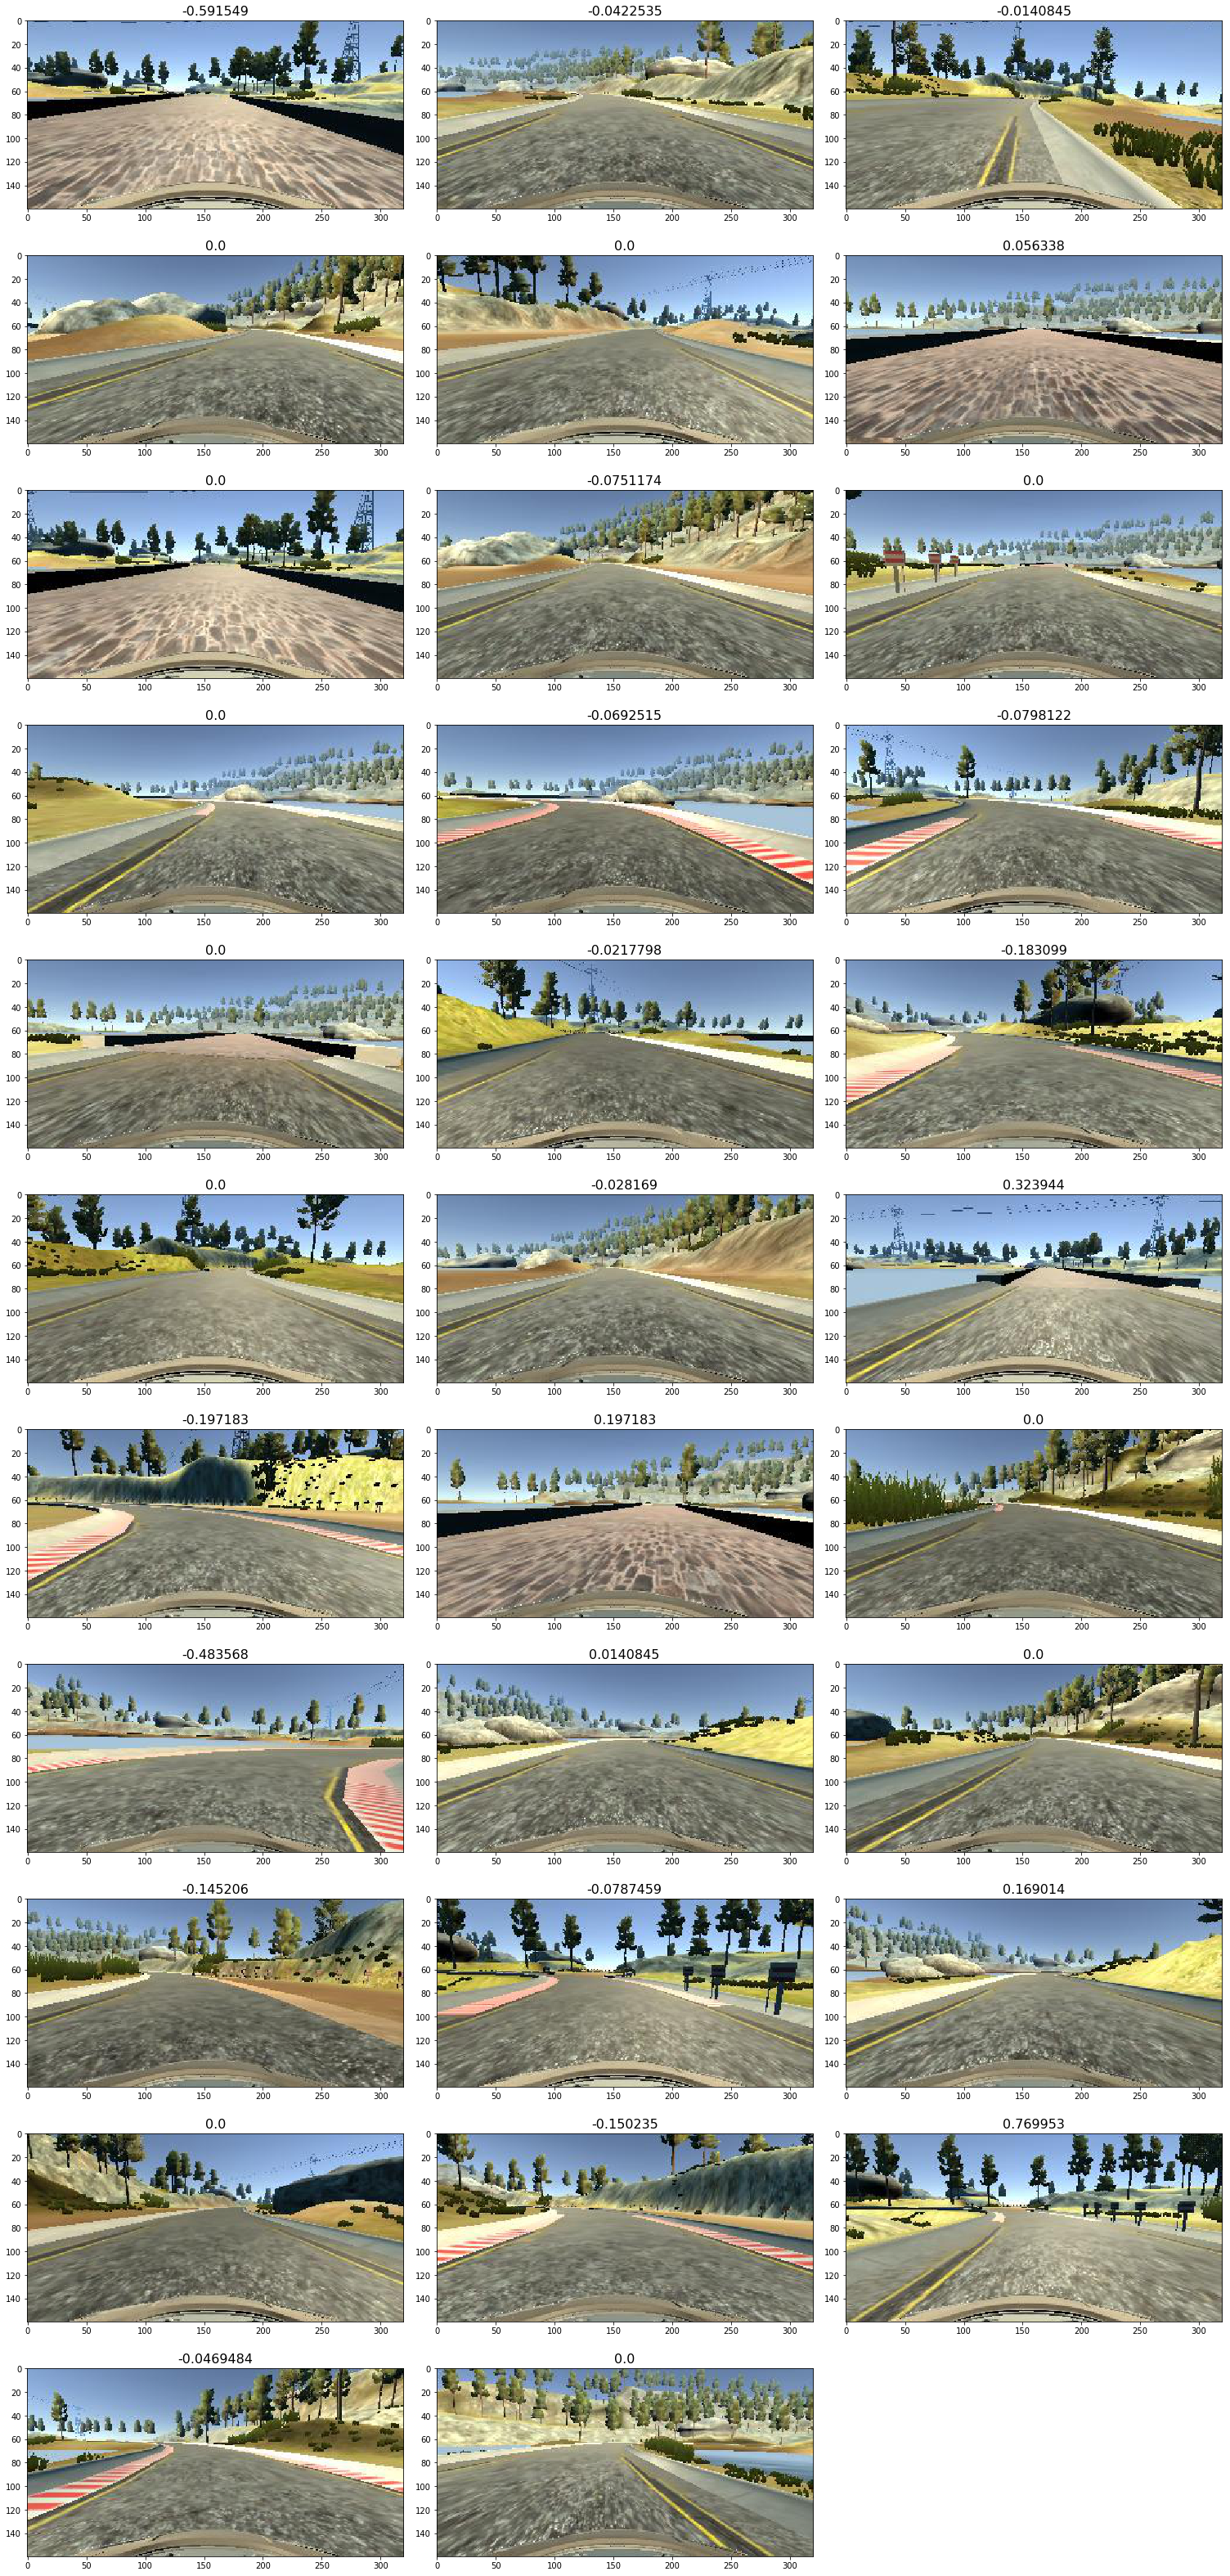

In [16]:
plot_images(X, titles= y, fontsize=16)

#### VGG Based Model

In [17]:
from keras.models import Model
from keras.layers import Input, Flatten, Dense, BatchNormalization, Dropout, Lambda, Cropping2D
from keras.optimizers import Adam
from keras import backend as K 

from keras.applications.vgg16 import VGG16, preprocess_input

In [18]:
def get_model_trainability(model):
    for layer in model.layers:
        print(layer.name), print("Convolution Layer:", 'conv' in layer.name), print("Trainable:", layer.trainable)
        print()    

In [19]:
# This Model uses transfer learning based on the VGG16 network

# Hypothesis: For the road images we don't need to recognize the details such as those with 
# faces (eg.: the cats and dogs). We may get by, by just taking VGG features from initial 
# layers (re-use VGG16 weights for initial layers) and retrain later layers.

# NOTE: for some reason the keras application VGG16 preprocessing function is not "found" when 
# running the model on the simulator (Autonomous mode) so I had to add the Lambda layer with
# those preprocessing operations.

def get_vgg_model(input_shape=image_shape, dropout=0.0, regularizer=None, 
                  conv_trainable=False, conv_blocks_to_freeze=5):
    
    image_input = Input(shape=image_shape, name='image_input')
    
    # [123.68, 116.779, 103.939] are the VGG16 RGB mean values of the training images (ImageNet) that 
    # the original VGG16 developers used for preprocessing the input images. 
    # We also need to reverse the RGB channels (to BGR) as the VGG16 uses BGR input images.

    image_input = Lambda(lambda x: (x - np.array([123.68, 116.779, 103.939]).reshape(1,1,3))[:, ::-1])(image_input)
    image_input = Cropping2D(cropping=((50,20), (0,0)))(image_input)
    
    vgg_model = VGG16(weights='imagenet', include_top=False, input_tensor=image_input)
    
    X = vgg_model.get_layer('block5_pool').output

    X = Dropout(dropout)(X)

    X = Flatten()(X)

    X = Dense(4096, activation='relu', name='fc1', kernel_regularizer=regularizer)(X)
    X = BatchNormalization()(X)
    X = Dropout(dropout)(X)
    X = Dense(4096, activation='relu', name='fc2', kernel_regularizer=regularizer)(X)
    X = BatchNormalization()(X)
    X = Dropout(dropout)(X)

    X = Dense(2048, activation='relu', name='fc3', kernel_regularizer=regularizer)(X)
    X = BatchNormalization()(X)
    X = Dropout(dropout)(X)
    X = Dense(1024, activation='relu', name='fc4', kernel_regularizer=regularizer)(X)
    X = BatchNormalization()(X)
    X = Dropout(dropout)(X)

    Pred = Dense(1, activation=None, name='y_hat')(X)

    model = Model(inputs=[vgg_model.input], outputs=Pred)

    # Freeze initial layers as requested
    if conv_trainable == False:
        layers = np.array([5,3,4,4,4])
        conv_layers_to_freeze = np.sum(layers[:conv_blocks_to_freeze])
        for layer in model.layers[1:]:
            layer.trainable = False
            conv_layers_to_freeze -= 1
            if conv_layers_to_freeze <= 0 : break

    return model


In [20]:
# Freeze weights of first 2 Conv blocks only 
vgg_based_model = get_vgg_model(dropout=0.5, conv_blocks_to_freeze=2)

In [21]:
vgg_based_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 160, 320, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 90, 320, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 90, 320, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 45, 160, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 45, 160, 128)      73856     
__________

In [22]:
# Check model trainability
get_model_trainability(vgg_based_model)

image_input
Convolution Layer: False
Trainable: False

lambda_1
Convolution Layer: False
Trainable: False

cropping2d_1
Convolution Layer: False
Trainable: False

block1_conv1
Convolution Layer: True
Trainable: False

block1_conv2
Convolution Layer: True
Trainable: False

block1_pool
Convolution Layer: False
Trainable: False

block2_conv1
Convolution Layer: True
Trainable: False

block2_conv2
Convolution Layer: True
Trainable: False

block2_pool
Convolution Layer: False
Trainable: False

block3_conv1
Convolution Layer: True
Trainable: True

block3_conv2
Convolution Layer: True
Trainable: True

block3_conv3
Convolution Layer: True
Trainable: True

block3_pool
Convolution Layer: False
Trainable: True

block4_conv1
Convolution Layer: True
Trainable: True

block4_conv2
Convolution Layer: True
Trainable: True

block4_conv3
Convolution Layer: True
Trainable: True

block4_pool
Convolution Layer: False
Trainable: True

block5_conv1
Convolution Layer: True
Trainable: True

block5_conv2
Convolut

In [21]:
lr = 0.001
optimizer = Adam(lr=lr)
# optimizer = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
# regularizer = None #l2(0.01)
# dropout = 0.0

In [23]:
vgg_based_model.compile(loss='mse', optimizer=optimizer)

In [24]:
# Epoch 10
history1 = vgg_based_model.fit_generator(
    train_gen, 
    steps_per_epoch=int(X_train.shape[0]/batch_size), 
    validation_data=val_gen, 
    validation_steps=int(X_val.shape[0]/batch_size), 
    epochs=10)

Epoch 1/10
865/865 [==============================] - 633s 731ms/step - loss: 0.8893 - val_loss: 0.0513
Epoch 2/10
865/865 [==============================] - 760s 879ms/step - loss: 0.0627 - val_loss: 0.0562
Epoch 3/10
865/865 [==============================] - 756s 874ms/step - loss: 0.0631 - val_loss: 0.0565
Epoch 4/10
865/865 [==============================] - 750s 867ms/step - loss: 0.0649 - val_loss: 0.0374
Epoch 5/10
865/865 [==============================] - 742s 858ms/step - loss: 0.0543 - val_loss: 0.0522
Epoch 6/10
865/865 [==============================] - 745s 861ms/step - loss: 0.0576 - val_loss: 0.1150
Epoch 7/10
865/865 [==============================] - 732s 846ms/step - loss: 0.0547 - val_loss: 0.0765
Epoch 8/10
865/865 [==============================] - 714s 825ms/step - loss: 0.0507 - val_loss: 0.0374
Epoch 9/10
865/865 [==============================] - 701s 810ms/step - loss: 0.0490 - val_loss: 0.0367
Epoch 10/10
865/865 [==============================] - 706s 816m

In [25]:
vgg_based_model.save(model_path+'model_ep10.h5')

In [23]:
# vgg_based_model = load_model(model_path+'model_ep10.h5')

In [26]:
vgg_based_model.optimizer = Adam(lr=0.0005)

In [27]:
# Epoch 11 to 20
history2 = vgg_based_model.fit_generator(
    train_gen, 
    steps_per_epoch=int(X_train.shape[0]/batch_size), 
    validation_data=val_gen, 
    validation_steps=int(X_val.shape[0]/batch_size), 
    epochs=10)

Epoch 1/10
865/865 [==============================] - 695s 803ms/step - loss: 0.0537 - val_loss: 0.0339
Epoch 2/10
865/865 [==============================] - 704s 813ms/step - loss: 0.0478 - val_loss: 0.0325
Epoch 3/10
865/865 [==============================] - 703s 812ms/step - loss: 0.0467 - val_loss: 0.0379
Epoch 4/10
865/865 [==============================] - 705s 815ms/step - loss: 0.0451 - val_loss: 0.0341
Epoch 5/10
865/865 [==============================] - 701s 810ms/step - loss: 0.0424 - val_loss: 0.0383
Epoch 6/10
865/865 [==============================] - 699s 808ms/step - loss: 0.0410 - val_loss: 0.0322
Epoch 7/10
865/865 [==============================] - 703s 813ms/step - loss: 0.0382 - val_loss: 0.0381
Epoch 8/10
865/865 [==============================] - 698s 807ms/step - loss: 0.0367 - val_loss: 0.0382
Epoch 9/10
865/865 [==============================] - 700s 809ms/step - loss: 0.0346 - val_loss: 0.0384
Epoch 10/10
865/865 [==============================] - 698s 807m

In [28]:
vgg_based_model.save(model_path+'model_ep20.h5')

In [29]:
vgg_based_model.optimizer = Adam(lr=0.0001)

In [30]:
# Epoch 21 to 30
history3 = vgg_based_model.fit_generator(
    train_gen, 
    steps_per_epoch=int(X_train.shape[0]/batch_size), 
    validation_data=val_gen, 
    validation_steps=int(X_val.shape[0]/batch_size), 
    epochs=10)

Epoch 1/10
865/865 [==============================] - 696s 804ms/step - loss: 0.0322 - val_loss: 0.0316
Epoch 2/10
865/865 [==============================] - 700s 809ms/step - loss: 0.0307 - val_loss: 0.0331
Epoch 3/10
865/865 [==============================] - 700s 809ms/step - loss: 0.0291 - val_loss: 0.0328
Epoch 4/10
865/865 [==============================] - 699s 808ms/step - loss: 0.0278 - val_loss: 0.0267
Epoch 5/10
865/865 [==============================] - 699s 808ms/step - loss: 0.0264 - val_loss: 0.0294
Epoch 6/10
865/865 [==============================] - 696s 805ms/step - loss: 0.0255 - val_loss: 0.0237
Epoch 7/10
865/865 [==============================] - 698s 806ms/step - loss: 0.0243 - val_loss: 0.0245
Epoch 8/10
865/865 [==============================] - 699s 808ms/step - loss: 0.0231 - val_loss: 0.0253
Epoch 9/10
865/865 [==============================] - 699s 808ms/step - loss: 0.0219 - val_loss: 359.4884
Epoch 10/10
865/865 [==============================] - 713s 82

In [ ]:
vgg_based_model.save(model_path+'model_ep30.h5')

In [23]:
vgg_based_model = load_model(model_path+'model_ep30.h5')

In [25]:
# Epoch 31 to 40
history4 = vgg_based_model.fit_generator(
    train_gen, 
    steps_per_epoch=int(X_train.shape[0]/batch_size), 
    validation_data=val_gen, 
    validation_steps=int(X_val.shape[0]/batch_size), 
    epochs=10)

Epoch 1/10
865/865 [==============================] - 572s 661ms/step - loss: 0.0176 - val_loss: 0.0188
Epoch 2/10
865/865 [==============================] - 687s 794ms/step - loss: 0.0163 - val_loss: 0.0180
Epoch 3/10
865/865 [==============================] - 674s 779ms/step - loss: 0.0160 - val_loss: 0.0176
Epoch 4/10
865/865 [==============================] - 651s 752ms/step - loss: 0.0153 - val_loss: 0.0171
Epoch 5/10
865/865 [==============================] - 637s 737ms/step - loss: 0.0149 - val_loss: 0.0168
Epoch 6/10
865/865 [==============================] - 625s 722ms/step - loss: 0.0145 - val_loss: 0.0166
Epoch 7/10
865/865 [==============================] - 627s 725ms/step - loss: 0.0139 - val_loss: 0.0166
Epoch 8/10
865/865 [==============================] - 623s 721ms/step - loss: 0.0137 - val_loss: 0.0164
Epoch 9/10
865/865 [==============================] - 607s 702ms/step - loss: 0.0134 - val_loss: 0.0161
Epoch 10/10
865/865 [==============================] - 590s 682m

In [26]:
vgg_based_model.save(model_path+'model_ep40.h5')

In [22]:
vgg_based_model = load_model(model_path+'model_ep40.h5')

In [24]:
vgg_based_model.optimizer = Adam(lr=0.00001)

In [25]:
# Epoch 41 to 60
history5 = vgg_based_model.fit_generator(
    train_gen, 
    steps_per_epoch=int(X_train.shape[0]/batch_size), 
    validation_data=val_gen, 
    validation_steps=int(X_val.shape[0]/batch_size), 
    epochs=20)

Epoch 1/20
865/865 [==============================] - 576s 666ms/step - loss: 0.0127 - val_loss: 0.0158
Epoch 2/20
865/865 [==============================] - 595s 688ms/step - loss: 0.0123 - val_loss: 0.0154
Epoch 3/20
865/865 [==============================] - 548s 633ms/step - loss: 0.0120 - val_loss: 0.0154
Epoch 4/20
865/865 [==============================] - 546s 631ms/step - loss: 0.0117 - val_loss: 0.0156
Epoch 5/20
865/865 [==============================] - 538s 622ms/step - loss: 0.0114 - val_loss: 0.0152
Epoch 6/20
865/865 [==============================] - 522s 604ms/step - loss: 0.0112 - val_loss: 0.0148
Epoch 7/20
865/865 [==============================] - 524s 605ms/step - loss: 0.0108 - val_loss: 0.0151
Epoch 8/20
865/865 [==============================] - 530s 613ms/step - loss: 0.0107 - val_loss: 0.0150
Epoch 9/20
865/865 [==============================] - 529s 611ms/step - loss: 0.0105 - val_loss: 0.0148
Epoch 10/20
865/865 [==============================] - 531s 614m

In [26]:
vgg_based_model.save(model_path+'model_ep60.h5')

**Comment on the Autonomous Drive Test result:**

The **'model_ep40.h5'** showed the best result when run in autonomous mode and is the one used to generate the video and **was also renamed to 'model.h5' as required by the project naming conventions**. The 'model_ep60.h5' result was ok but exhibited few jerky movements of the vehicle and also drove over the lane lines at a few locations.

Observation: The model @ep40 (40 epochs) shows a little bit of overfitting, but probably not much as the autonomous drive result was good. If we see after 50 epochs (Epoch 10/20 above in the ep41-60 run), the overfitting seems to be increasing and could possibly be the reason for the jerky movements I saw in the autonomous drive test for 'model_ep60.h5'.

Only the **'model_ep40.h5'** renamed to **'model.h5'** is uploaded to the git repo.